# 序列模型

使用正弦函数和一些可加性噪声来生成序列数据，
时间步为$1, 2, \ldots, 1000$

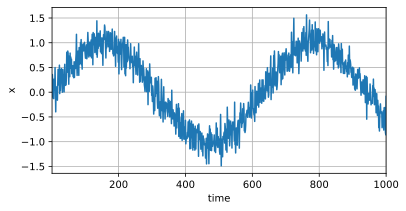

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000 # 定义时间序列的总长度，即包含 1000 个时间步
'''
生成一个从1到1000的时间索引张量。
torch.arange类似于Python的range，但返回PyTorch张量。
dtype=torch.float32 指定数据类型为32位浮点数，便于后续数学运算。
'''
time = torch.arange(1, T + 1, dtype=torch.float32)
'''
第一部分：torch.sin(0.01 * time)
生成一个正弦波信号。
0.01 * time 将时间索引缩放，使得正弦波在 1000 个时间步内完成约 1.59 个周期（因为 2π / 0.01 ≈ 628，1000/628 ≈ 1.59）。
第二部分：torch.normal(0, 0.2, (T,))
生成均值为 0、标准差为0.2的高斯噪声。
(T,) 指定噪声张量的形状为 (1000,)，与信号长度匹配。
'''
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
'''
time：x轴数据（时间索引）。
[x]：y轴数据，用列表包裹表示可以绘制多条线（这里只有一条）。
'time'：x轴标签。
'x'：y 轴标签。
xlim=[1, 1000]：设置 x 轴显示范围为 1 到 1000。
figsize=(6, 3)：设置图像尺寸为 6×3 英寸。
'''
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

将数据映射为数据对$y_t = x_t$
和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$

In [2]:
'''
定义时间窗口大小为 4，即用过去4个时间步的数据来预测下一个时间步的值。
这是自回归模型的阶数（order），类似于AR(4)模型。
'''
tau = 4
'''
初始化一个特征矩阵，形状为 (1000-4, 4) = (996, 4)。
行数：T - tau = 996，表示可构造 996 个训练样本（前4个点无法形成完整窗口）。
列数：tau = 4，表示每个样本包含 4 个滞后特征。
'''
features = torch.zeros((T - tau, tau))
'''
i=0：第0列取 x[0:996]（第0-995个观测值）
i=1：第1列取 x[1:997]（第1-996个观测值）
i=2：第2列取 x[2:998]（第2-997个观测值）
i=3：第3列取 x[3:999]（第3-998个观测值）
结果：features 的每一行是一个样本，例如第 t 行为 [x[t], x[t+1], x[t+2], x[t+3]]。
'''
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
'''
从x[4]开始取值（第4到999个观测值），共996个标签,重塑为形状(996, 1)的列向量。
逻辑：用历史4步预测第5步的值，即 features[t] → labels[t]。
'''
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600 # 每个训练批次含16个样本;前600个样本用作训练集，剩余396个用于测试/验证
'''
使用d2l工具函数创建PyTorch数据加载器（DataLoader）。
(features[:n_train], labels[:n_train])：传入训练集特征和标签。
is_train=True：启用数据打乱（shuffle），增加训练随机性。
'''
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

使用一个相当简单的架构训练模型：
一个拥有两个全连接层的多层感知机

In [3]:
def init_weights(m):
    if type(m) == nn.Linear: # 过无需初始化的层（如激活函数 ReLU）
        '''
        Xavier均匀初始化：将权重m.weight从[-a, a]的均匀分布中采样，其中a =gain*sqrt(6/(fan_in + fan_out))
        作用：保持前向/反向传播时梯度方差稳定，缓解梯度消失/爆炸，特别适合ReLU激活函数。
        原地修改：函数名末尾的 _ 表示直接修改张量，不返回新值。
        '''
        nn.init.xavier_uniform_(m.weight)
'''
nn.Linear(4, 10)：输入层，4个输入特征（对应tau=4的时间窗口），映射到10个隐藏单元。
nn.ReLU()：激活函数，引入非线性能力。
nn.Linear(10, 1)：输出层，10个隐藏单元映射到1个输出值（即下一个时间步的预测值）。
'''
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    # 递归应用：将init_weights函数作用于net中的所有子模块。
    # 结果：所有nn.Linear层的权重都被Xavier初始化，偏置bias默认初始化为零。
    net.apply(init_weights)
    return net
'''
reduction='none' ：不进行降维，返回每个样本的独立损失值，形状为 (batch_size, 1)。
灵活性：便于后续调试、按样本加权，或在训练循环中手动计算平均损失（.mean()）。
'''
loss = nn.MSELoss(reduction='none')

训练模型

In [4]:
'''
net:要训练的模型（之前定义的MLP）
train_iter:训练数据加载器（批量大小为16）
loss:损失函数（按样本返回的MSELoss）
epochs:训练轮数（5轮）
lr:学习率（0.01）
'''
def train(net, train_iter, loss, epochs, lr):
    '''
    创建Adam优化器：自动调整学习率，适合处理非平稳目标和时间序列数据。
    net.parameters()：获取模型中所有可训练的权重和偏置参数。lr=0.01：初始学习率。
    '''
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs): # 遍历 5个训练轮次，每轮遍历全部训练数据一次。
        # X: 特征，形状 (16, 4)（16个样本，每个样本4个时间步）
        # y: 标签，形状 (16, 1)（16个预测目标值）
        for X, y in train_iter:
            # 梯度清零：清除上一批次计算留下的梯度信息，避免累积
            trainer.zero_grad()
            # 前向传播：net(X)生成预测值，形状与y匹配(16, 1)。
            # 计算损失：loss计算每个样本的MSE，返回形状(16, 1)的张量l。
            l = loss(net(X), y)
            '''
            l.sum()：将批次中所有样本的损失求和，得到一个标量。
            .backward() ：执行反向传播，计算损失相对于所有模型参数的梯度，并存储在参数的.grad属性中。
            '''
            l.sum().backward()
            # 参数更新：优化器根据计算出的梯度，使用Adam算法更新模型权重和偏置
            trainer.step()
        # 打印日志：每完成一个epoch，计算并打印训练集上的平均损失。
        # d2l.evaluate_loss()：likely在评估模式下遍历整个训练集，计算平均MSE用于监控。
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.065337
epoch 2, loss: 0.050714
epoch 3, loss: 0.049207
epoch 4, loss: 0.048818
epoch 5, loss: 0.048791


模型预测下一个时间步

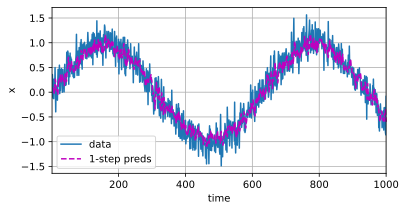

In [5]:
'''
全量预测：将完整的特征矩阵（形状(996,4)）输入训练好的模型net。
输出：onestep_preds是模型对所有时间步的预测值，张量形状为 (996,1)。
含义：模型基于每个时刻的前4个真实观测值 预测当前时刻的值（单步滚动预测）。
'''
onestep_preds = net(features)
'''
双时间序列绘图：同时绘制两条曲线。
time：完整时间索引[1,2,...,1000]，用于绘制原始数据。
time[tau:]：从索引tau（即 5）开始的时间索引 [5,6,...,1000]，用于绘制预测数据（因为前4步无法预测）。
'''
d2l.plot([time, time[tau:]],
        '''
        原始数据：x.detach().numpy()将原始序列张量转换为NumPy数组，对应time。
        预测数据：onestep_preds.detach().numpy()将预测结果转换为NumPy数组，对应time[tau:]。
        .detach()：切断梯度计算链，避免内存泄漏（预测时无需反向传播）。
        .numpy()：转换为NumPy格式，满足Matplotlib绘图要求。
        '''
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
        '''
        坐标轴标签：x 轴为"time"，y 轴为"x"（序列值）。
        图例说明：两条线分别标记为"data"（真实数据和"1-step preds"（单步预测）。
        x 轴范围：固定在1到1000，完整展示时间跨度。
        图像尺寸：宽6英寸，高3英寸。
        '''
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

进行多步预测

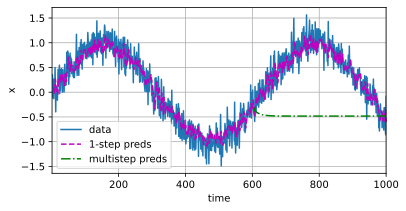

In [6]:
multistep_preds = torch.zeros(T) # 创建一个长度为T=1000的零张量，用于存储多步预测结果
# 初始化 ：将前n_train+tau=600+4=604个位置填充为真实观测值。
# 目的：为后续预测提供初始历史窗口（前4个真实值必须存在才能启动预测）。
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T): # 多步预测循环：从第605个位置（索引604）开始，迭代预测直到序列末尾（第1000个位置）
    '''
    multistep_preds[i - tau:i]：取出前4个预测值（注意：不再是真实值！）。
    .reshape((1, -1))：重塑为(1,4)的批次格式，符合模型输入要求。
    net(...)：模型基于自己之前的预测，生成下一个预测值。
    关键点：预测误差会累积放大，因为每一步的输入都包含之前预测的误差，这是多步预测的本质挑战。
    '''
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))
'''
time：完整时间轴 [1, ..., 1000]，对应原始数据（蓝色）。
time[tau:]：从第5步开始 [5, ..., 1000]，对应单步预测（橙色）。
time[n_train + tau:]：从第605步开始 [605, ..., 1000]，对应多步预测（绿色）。
'''
d2l.plot([time, time[tau:], time[n_train + tau:]],
        '''
        x：真实观测数据。
        onestep_preds：单步预测（基于真实历史，误差小）。
        multistep_preds[n_train + tau:]：多步预测（仅展示测试集部分，从605开始）。
        '''
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

更仔细地看一下$k$步预测

行数：T - tau - max_steps + 1<br>
问题本质：从序列的哪些位置启动多步预测？<br>
最小起始索引：0（从第1个时间点开始，用 x[0:tau] 预测 x[tau]）<br>
最大起始索引：T - tau - max_steps（最后能完整预测的位置）<br>
推导：假设起始索引为 s，需满足：<br>
输入窗口：x[s : s+tau] → 最后一个索引是 s+tau-1<br>
预测窗口：x[s+tau : s+tau+max_steps] → 最后一个索引是 s+tau+max_steps-1<br>
序列最大索引是 T-1，所以 s+tau+max_steps-1 ≤ T-1<br>
解得：s ≤ T - tau - max_steps<br>
起始点总数 = 最大索引 - 最小索引 + 1= (T - tau - max_steps) - 0 + 1= T - tau - max_steps + 1<br>
实例：当 T=1000, tau=4, max_steps=64<br>
行数 = 1000 - 4 - 64 + 1 = 933，意味着能从 933个不同位置 启动预测。<br>
列数：tau + max_steps<br>
问题本质：每行存储什么内容？<br>
前 tau 列：真实历史值（输入特征）<br>
列0: x[s]<br>
列1: x[s+1]<br>
...<br>
列 tau-1: x[s+tau-1]<br>
后 max_steps 列：递归预测值（逐步累积误差）<br>
列 tau: 预测 x[s+tau]<br>
列 tau+1: 预测 x[s+tau+1]（依赖列 tau 的预测值）<br>
...<br>
列 tau+max_steps-1: 预测 x[s+tau+max_steps-1]<br>
总列数 = 历史窗口 + 预测窗口 = tau + max_steps

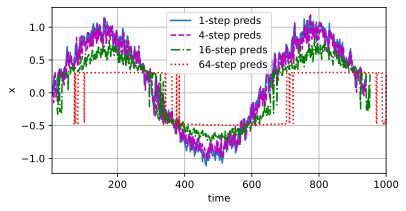

In [7]:
max_steps = 64 # 定义最大预测步长为64，即预测未来64个时间步
# 行数：1000-4-64+1=933，表示从933个不同起始点进行预测。
# 列数：4+64=68，前4列是真实历史值，后64列是递归预测值。
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
'''
填充初始特征窗口（前 4 列的真实值）
features[:, 0] = x[0:933]
features[:, 1] = x[1:934]
features[:, 2] = x[2:935]
features[:, 3] = x[3:936]
结果：每行 j 的前 4 列是 [x[j], x[j+1], x[j+2], x[j+3]]，提供预测起点
'''
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]
'''
递归多步预测的核心循环（i从4到67）：
features[:,i]=net(features[:,i-tau:i]).reshape(-1)：
对每一行，取前tau列作为输入，预测下一个值。
关键点：随着i增大，输入中包含越来越多模型自己之前的预测值（而非真实值），误差会指数级累积。
'''
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
# 选择 4 个典型步长进行可视化，展示预测质量随步长的退化过程
steps = (1, 4, 16, 64)
'''
时间轴：time[tau + i - 1: T - max_steps + i]，对齐不同步长的预测起始点。
预测值：features[:, (tau + i - 1)]，提取对应步长的预测列（如 i=1 是第 4 列，i=64 是第 67 列）。
图例：标记为 "1-step preds"、"4-step preds" 等
'''
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))